## Задача:
Подготовить данные для последующей обработки. Для этого мы 
1. Нормализуем все данные. Скалируем все данные в диапозоне 1-/1.
2. Обрабатываем пропуски. Обрабатываем выбросы.
3. Строим матрицу корреляции.
4. Строим гистограммы распределения
5. Ищем (взоимозависимые данные).
6. Тест на нормальность

Данные мы берем с сайта типа UCI для логистической регресии.

In [1]:
# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

# будем отображать графики прямо в jupyter'e
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
import pandas as pd

В качестве примера взяты данные https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip

In [2]:
import io
import zipfile
import requests  # $ pip install requests

r = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip")
with r, zipfile.ZipFile(io.BytesIO(r.content)) as archive:
    archive.extractall('tmp')

In [3]:
data = pd.read_csv('tmp/AirQualityUCI.csv',sep=';',decimal=',',parse_dates=[['Date', 'Time']])
#в файле изначально есть как . так и , разделителем, дата в файле записана в 2 поля - объединяем в 1.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 16 columns):
Date_Time        9471 non-null object
CO(GT)           9357 non-null float64
PT08.S1(CO)      9357 non-null float64
NMHC(GT)         9357 non-null float64
C6H6(GT)         9357 non-null float64
PT08.S2(NMHC)    9357 non-null float64
NOx(GT)          9357 non-null float64
PT08.S3(NOx)     9357 non-null float64
NO2(GT)          9357 non-null float64
PT08.S4(NO2)     9357 non-null float64
PT08.S5(O3)      9357 non-null float64
T                9357 non-null float64
RH               9357 non-null float64
AH               9357 non-null float64
Unnamed: 15      0 non-null float64
Unnamed: 16      0 non-null float64
dtypes: float64(15), object(1)
memory usage: 1.2+ MB


In [5]:
data.head()

,Date_Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004 18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004 19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004 20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004 21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004 22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


In [6]:
data.columns

Index(['Date_Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH', 'Unnamed: 15', 'Unnamed: 16'],
      dtype='object')

Далее мы видим что у нас есть 2 поля в которых нет некакой информации. В дальнейшем мыв их удаляем.

In [7]:
data['Unnamed: 16'].median
data['Unnamed: 15'].median
#data['date']=pd.to_datetime(data['Date'], format='%Y/%m/%d',errors='coerce')
#data['time']=pd.to_datetime(data['Time'], format='%H/%M/%S',errors='coerce')
#data['datetime']=pd.to_datetime(data['date']+' '+data['time'], errors='coerce' )
#data

<bound method Series.median of 0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
9466   NaN
9467   NaN
9468   NaN
9469   NaN
9470   NaN
Name: Unnamed: 15, Length: 9471, dtype: float64>

In [8]:
data = data.drop(['Unnamed: 16','Unnamed: 15'], axis=1).dropna() #
#мы удаляем 2 строки в которых нет данных а потом удаляем все строки где есть пропуски

In [9]:
data.shape

(9357, 14)

### удаляем выбросы


In [10]:
from scipy import stats
filt_df = data.loc[:, data.columns != 'Date_Time']
filt_df=filt_df[(np.abs(stats.zscore(filt_df)) < 3).all(axis=1)]  #мы удяем все выьбросы , точнее удаляем все данные которые не находяться в пределах 3х стандартных отклонений
filt_dfs = pd.concat([data.loc[:,'Date_Time'], filt_df], axis=1)


In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
scalerminmax = MinMaxScaler(feature_range=(-1,1))#нормируем все поля кроме даты и используя minmax скалер преобразуем данные. 
#filt_df = scaler.fit_transform(filt_df.values)

filt_dfs [['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH']] = scalerminmax.fit_transform (filt_dfs [['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH']])

filt_dfs

,Date_Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004 18.00.00,0.942474,0.138866,0.521739,-0.489177,-0.124174,-0.357331,0.017519,0.174484,0.035240,-0.010906,-0.333333,-0.001258,-0.439867
1,10/03/2004 19.00.00,0.936721,0.027116,0.356522,-0.597403,-0.244386,-0.467954,0.182901,0.095685,-0.086499,-0.291607,-0.346237,-0.031447,-0.471436
2,10/03/2004 20.00.00,0.938639,0.207888,0.252174,-0.614719,-0.265522,-0.418788,0.135249,0.178236,-0.090160,-0.194879,-0.406452,0.127044,-0.447295
3,10/03/2004 21.00.00,0.938639,0.165160,0.217391,-0.606061,-0.253633,-0.346795,0.067975,0.208255,-0.063616,-0.072546,-0.445161,0.277987,-0.411621
4,10/03/2004 22.00.00,0.932886,-0.005752,0.091304,-0.722944,-0.401585,-0.418788,0.226349,0.185741,-0.149657,-0.160740,-0.436559,0.267925,-0.409568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,04/04/2005 10.00.00,0.947267,0.063270,-1.000000,-0.419913,-0.051519,0.179982,-0.707078,0.463415,-0.255835,0.426268,0.023656,-0.494340,-0.440844
9353,04/04/2005 11.00.00,0.940556,-0.184881,-1.000000,-0.510823,-0.149273,-0.028973,-0.615978,0.422139,-0.356522,-0.009957,0.126882,-0.635220,-0.484729
9354,04/04/2005 12.00.00,0.940556,-0.219392,-1.000000,-0.467532,-0.101717,-0.134328,-0.617379,0.407129,-0.377574,-0.177809,0.238710,-0.771069,-0.554415
9355,04/04/2005 13.00.00,0.937680,-0.447823,-1.000000,-0.593074,-0.236460,-0.236172,-0.478626,0.335835,-0.560641,-0.483167,0.298925,-0.891824,-0.678249


In [12]:
#матрица корреляции и ее визуализация
corr_matrix = filt_dfs.drop(['Date_Time'], axis=1).corr()
corr_matrix

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
CO(GT),1.000000,0.088024,0.112167,0.037206,0.048168,0.554533,-0.070427,0.671049,-0.094019,0.098219,-0.128406,-0.022844,-0.185039
PT08.S1(CO),0.088024,1.000000,0.034992,0.871916,0.882142,0.532591,-0.801160,0.276797,0.647370,0.891831,0.072587,0.111151,0.166198
NMHC(GT),0.112167,0.034992,1.000000,-0.088672,-0.080080,-0.063515,0.242505,0.049805,0.026011,-0.073467,-0.111698,0.018490,-0.147997
C6H6(GT),0.037206,0.871916,-0.088672,1.000000,0.983340,0.486127,-0.761235,0.224986,0.752960,0.853074,0.241561,-0.086173,0.203081
PT08.S2(NMHC),0.048168,0.882142,-0.080080,0.983340,1.000000,0.492849,-0.815622,0.248221,0.760166,0.868449,0.276413,-0.111876,0.215458
NOx(GT),0.554533,0.532591,-0.063515,0.486127,0.492849,1.000000,-0.505324,0.840314,0.088823,0.586906,-0.232225,0.091530,-0.212149
PT08.S3(NOx),-0.070427,-0.801160,0.242505,-0.761235,-0.815622,-0.505324,1.000000,-0.277031,-0.526262,-0.818408,-0.150537,-0.055863,-0.241276
NO2(GT),0.671049,0.276797,0.049805,0.224986,0.248221,0.840314,-0.277031,1.000000,-0.019343,0.304862,-0.132862,-0.090082,-0.252926
PT08.S4(NO2),-0.094019,0.647370,0.026011,0.752960,0.760166,0.088823,-0.526262,-0.019343,1.000000,0.558871,0.602644,-0.043763,0.674204
PT08.S5(O3),0.098219,0.891831,-0.073467,0.853074,0.868449,0.586906,-0.818408,0.304862,0.558871,1.000000,-0.012402,0.121882,0.090664


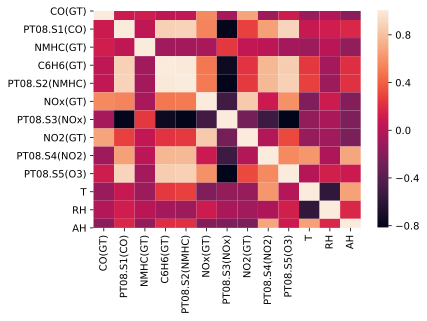

In [13]:
sns.heatmap(corr_matrix);


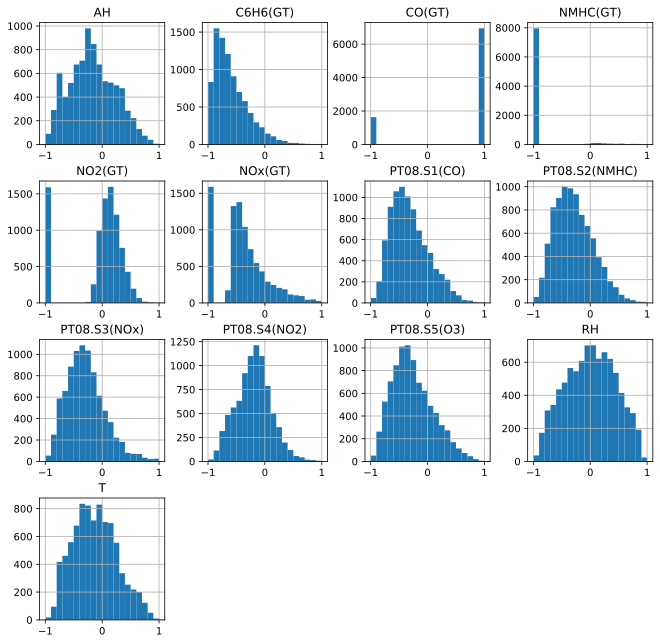

In [14]:
#строим гистограммы и т д...
filt_dfs.hist(bins=20,figsize=(11,11));

In [15]:
filt_dfs

,Date_Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004 18.00.00,0.942474,0.138866,0.521739,-0.489177,-0.124174,-0.357331,0.017519,0.174484,0.035240,-0.010906,-0.333333,-0.001258,-0.439867
1,10/03/2004 19.00.00,0.936721,0.027116,0.356522,-0.597403,-0.244386,-0.467954,0.182901,0.095685,-0.086499,-0.291607,-0.346237,-0.031447,-0.471436
2,10/03/2004 20.00.00,0.938639,0.207888,0.252174,-0.614719,-0.265522,-0.418788,0.135249,0.178236,-0.090160,-0.194879,-0.406452,0.127044,-0.447295
3,10/03/2004 21.00.00,0.938639,0.165160,0.217391,-0.606061,-0.253633,-0.346795,0.067975,0.208255,-0.063616,-0.072546,-0.445161,0.277987,-0.411621
4,10/03/2004 22.00.00,0.932886,-0.005752,0.091304,-0.722944,-0.401585,-0.418788,0.226349,0.185741,-0.149657,-0.160740,-0.436559,0.267925,-0.409568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,04/04/2005 10.00.00,0.947267,0.063270,-1.000000,-0.419913,-0.051519,0.179982,-0.707078,0.463415,-0.255835,0.426268,0.023656,-0.494340,-0.440844
9353,04/04/2005 11.00.00,0.940556,-0.184881,-1.000000,-0.510823,-0.149273,-0.028973,-0.615978,0.422139,-0.356522,-0.009957,0.126882,-0.635220,-0.484729
9354,04/04/2005 12.00.00,0.940556,-0.219392,-1.000000,-0.467532,-0.101717,-0.134328,-0.617379,0.407129,-0.377574,-0.177809,0.238710,-0.771069,-0.554415
9355,04/04/2005 13.00.00,0.937680,-0.447823,-1.000000,-0.593074,-0.236460,-0.236172,-0.478626,0.335835,-0.560641,-0.483167,0.298925,-0.891824,-0.678249


In [16]:
from scipy import stats #проверяем корреляции
spear=stats.spearmanr(filt_dfs)


In [17]:
a=np.array(spear)


In [18]:
a.shape

(2, 14, 14)

In [19]:
def highlight_max(s):
    is_max = s > (s.max()/2)
    return ['background-color: red' if v else '' for v in is_max]

Положительные корреляции подразумевают, что с увеличением x увеличивается и y. Отрицательные корреляции подразумевают, что с увеличением x у уменьшается. Корреляция Спирмена не подразумевает что данные должны быть распределены нормально.

In [20]:
test=pd.DataFrame(a[0,::], columns=data.columns)
test.style.apply(highlight_max) 


,Date_Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,1,-0.0345989,-0.0253408,-0.0374091,-5.06187e-05,-0.0116596,0.00452125,0.0654954,-0.00389807,-0.0309274,-0.0651956,-0.0163586,-0.00702297,-0.035644
1,-0.0345989,1,0.647724,-0.202991,0.597665,0.621739,0.795054,-0.545907,0.710986,0.355576,0.593584,0.0688468,-0.073109,-0.0889932
2,-0.0253408,0.647724,1,-0.12917,0.831753,0.844528,0.593245,-0.787739,0.499207,0.645321,0.798344,0.185199,0.0451859,0.13184
3,-0.0374091,-0.202991,-0.12917,1,-0.0213131,-0.035605,-0.382395,0.256614,-0.196048,0.295506,-0.186807,0.398224,-0.305014,0.252932
4,-5.06187e-05,0.597665,0.831753,-0.0213131,1,0.963424,0.528247,-0.742787,0.441325,0.721543,0.767207,0.331096,-0.112093,0.230759
5,-0.0116596,0.621739,0.844528,-0.035605,0.963424,1,0.536175,-0.793222,0.454084,0.717049,0.777992,0.306271,-0.159509,0.199286
6,0.00452125,0.795054,0.593245,-0.382395,0.528247,0.536175,1,-0.566391,0.821294,0.115283,0.614364,-0.153676,0.0524432,-0.216808
7,0.0654954,-0.545907,-0.787739,0.256614,-0.742787,-0.793222,-0.566391,1,-0.468048,-0.478358,-0.708024,-0.130808,-0.0124537,-0.132799
8,-0.00389807,0.710986,0.499207,-0.196048,0.441325,0.454084,0.821294,-0.468048,1,0.127817,0.484879,0.00697919,-0.207933,-0.319083
9,-0.0309274,0.355576,0.645321,0.295506,0.721543,0.717049,0.115283,-0.478358,0.127817,1,0.450326,0.663561,-0.111987,0.606493


Собственно говоря мы выделили данные которые коррелируют друг с другом... 

## Для еще 1 примера возьмем другие данные где есть категориальные признаки и где есть четкая цевая переменная.  

In [21]:
#https://archive.ics.uci.edu/ml/datasets/Facebook+metrics берем данные от сюда.

In [22]:
r = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip")
with r, zipfile.ZipFile(io.BytesIO(r.content)) as archive:
    archive.extractall('tmp')

In [23]:
newdata = pd.read_csv('tmp/dataset_Facebook.csv',sep=';') 

In [24]:
newdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
Page total likes                                                       500 non-null int64
Type                                                                   500 non-null object
Category                                                               500 non-null int64
Post Month                                                             500 non-null int64
Post Weekday                                                           500 non-null int64
Post Hour                                                              500 non-null int64
Paid                                                                   499 non-null float64
Lifetime Post Total Reach                                              500 non-null int64
Lifetime Post Total Impressions                                        500 non-null int64
Lifetime Engaged Users                                                 500 non-nul

In [25]:
newdata.columns #видим много колонок с длинными названиями и меняем их на более короткие

Index(['Page total likes', 'Type', 'Category', 'Post Month', 'Post Weekday',
       'Post Hour', 'Paid', 'Lifetime Post Total Reach',
       'Lifetime Post Total Impressions', 'Lifetime Engaged Users',
       'Lifetime Post Consumers', 'Lifetime Post Consumptions',
       'Lifetime Post Impressions by people who have liked your Page',
       'Lifetime Post reach by people who like your Page',
       'Lifetime People who have liked your Page and engaged with your post',
       'comment', 'like', 'share', 'Total Interactions'],
      dtype='object')

In [26]:

rename_dic = dict(zip(newdata.columns, 
                      ['page', 'Type', 'category', 'post month',
                       'post weekday', 'post hour', 'paid', 'lifetime reach',
                       'lifetime impressions', 'lifetime users', 'lifetime consumers', 'Lifetime Page',
       'Lifetime like your Page',
       'Lifetime and engaged post',
       'comment', 'like', 'share', 'Total Interactions']))

In [27]:
newdata.rename(columns=rename_dic, inplace=True)

In [28]:
newdata['Type'].value_counts().head() #смотрим все варианты типов

Photo     426
Status     45
Link       22
Video       7
Name: Type, dtype: int64

In [29]:
newdata['Type']=newdata['Type'].map({'Status': 1,'Photo': 0,'Link': 2,'Video': 3}).fillna(4) #меняем тип тупе 

In [30]:
newdata = newdata.dropna() #удаляем пропуски

In [31]:
#newdata=newdata[(np.abs(stats.zscore(newdata)) < 4).all(axis=1)] # удалит больше чем нужно

In [32]:
newdata.shape

(495, 19)

и тут мы понимаем  что выбросы не являються выбросами а являються отличительными характеристиками наших данных и удалять их явно не стоит

In [33]:
newdata['Type'].value_counts().head() 

0    421
1     45
2     22
3      7
Name: Type, dtype: int64

In [34]:
new_corr_matrix = newdata.corr()

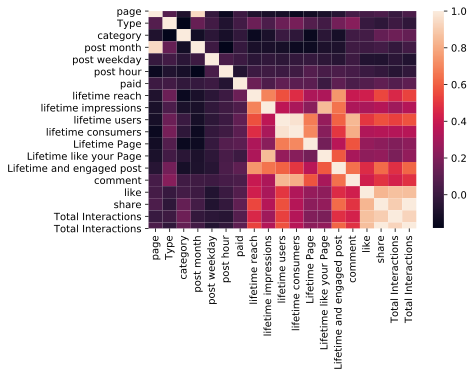

In [35]:
sns.heatmap(new_corr_matrix);


In [36]:
newdata.columns

Index(['page', 'Type', 'category', 'post month', 'post weekday', 'post hour',
       'paid', 'lifetime reach', 'lifetime impressions', 'lifetime users',
       'lifetime consumers', 'Lifetime Page', 'Lifetime like your Page',
       'Lifetime and engaged post', 'comment', 'like', 'share',
       'Total Interactions', 'Total Interactions'],
      dtype='object')

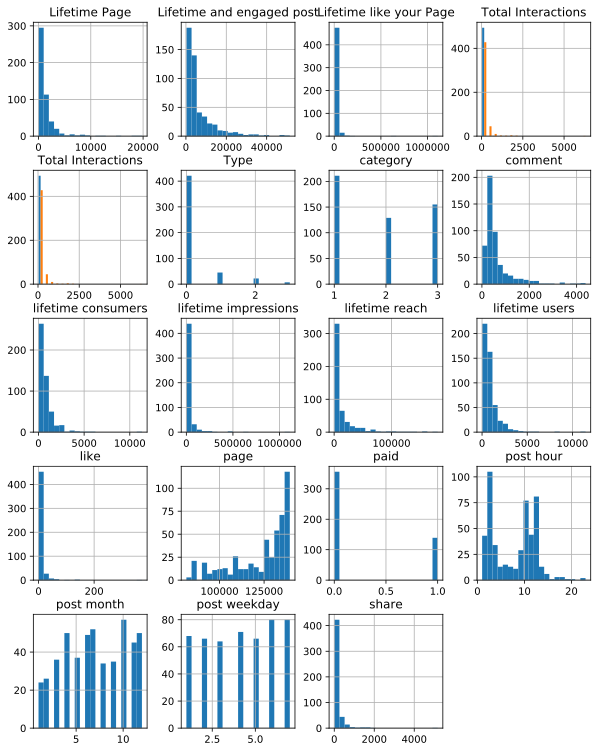

In [37]:
newdata.hist(bins=20,figsize=(10,13));

In [38]:
newdata [['page', 'Type', 'category', 'post month', 'post weekday', 'post hour',
       'paid', 'lifetime reach', 'lifetime impressions', 'lifetime users',
       'lifetime consumers', 'Lifetime Page', 'Lifetime like your Page',
       'Lifetime and engaged post', 'comment', 'like', 'share',
       'Total Interactions', 'Total Interactions']] = scalerminmax.fit_transform (newdata [['page', 'Type', 'category', 'post month', 'post weekday', 'post hour',
       'paid', 'lifetime reach', 'lifetime impressions', 'lifetime users',
       'lifetime consumers', 'Lifetime Page', 'Lifetime like your Page',
       'Lifetime and engaged post', 'comment', 'like', 'share',
       'Total Interactions', 'Total Interactions']])


In [39]:
newdata

,page,Type,category,post month,post weekday,post hour,paid,lifetime reach,lifetime impressions,lifetime users,lifetime consumers,Lifetime Page,Lifetime like your Page,Lifetime and engaged post,comment,like,share,Total Interactions,Total Interactions
0,1.000000,-1.000000,0.0,1.0,0.000000,-0.818182,-1.0,-0.972104,-0.991852,-0.970462,-0.982331,-0.984825,-0.995465,-0.945178,-0.949622,-0.978495,-0.969451,-0.968424,-0.968424
1,1.000000,-0.333333,0.0,1.0,-0.333333,-0.181818,-1.0,-0.886575,-0.966681,-0.746920,-0.761110,-0.831563,-0.979873,-0.770558,-0.496680,-0.973118,-0.949729,-0.948216,-0.948216
2,1.000000,-1.000000,1.0,1.0,-0.333333,-0.818182,-1.0,-0.975866,-0.993146,-0.970637,-0.981624,-0.985331,-0.995945,-0.950527,-0.943668,-1.000000,-0.974478,-0.974740,-0.974740
3,1.000000,-1.000000,0.0,1.0,-0.666667,-0.181818,1.0,-0.446411,-0.842444,-0.615136,-0.862002,-0.887709,-0.890794,0.242171,-0.369361,-0.688172,-0.392111,-0.438901,-0.438901
4,1.000000,-1.000000,0.0,1.0,-0.666667,-0.818182,-1.0,-0.922260,-0.976527,-0.884296,-0.929146,-0.942236,-0.989775,-0.884264,-0.822762,-0.897849,-0.874323,-0.875908,-0.875908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,-0.871778,-1.000000,1.0,-1.0,1.000000,-0.181818,-1.0,-0.942721,-0.984414,-0.860002,-0.868010,-0.899444,-0.990812,-0.883093,-0.810854,-0.946237,-0.951663,-0.944427,-0.944427
495,-0.871778,-1.000000,1.0,-1.0,1.000000,-0.909091,-1.0,-0.950666,-0.987445,-0.873460,-0.876491,-0.901265,-0.992444,-0.896915,-0.824594,-0.973118,-0.979505,-0.973476,-0.973476
496,-1.000000,-1.000000,0.0,-1.0,0.333333,-0.363636,-1.0,-0.964026,-0.989801,-0.907717,-0.911830,-0.931411,-0.993870,-0.927060,-0.866270,-1.000000,-0.979505,-0.976318,-0.976318
497,-1.000000,-1.000000,-1.0,-1.0,0.333333,-0.909091,-1.0,-0.960719,-0.988022,-0.892336,-0.900521,-0.920486,-0.992459,-0.915970,-0.837875,-0.978495,-0.964037,-0.963688,-0.963688


In [40]:
#возьмем какую нибудь лассо регрессию и посмотрим на получаемуе коэфициенты
newdatalasso = pd.read_csv('dataset_Facebook.csv',sep=';')

In [41]:
newdatalasso['Type']=newdatalasso['Type'].map({'Status': 1,'Photo': 0,'Link': 2,'Video': 3}).fillna(4) #меняем тип тупе 

In [42]:
newdatalasso = newdatalasso.dropna()

In [43]:
X = newdatalasso.drop('Type', axis=1)

In [44]:
y= newdatalasso['Type']

In [45]:
from sklearn.linear_model import Lasso

In [46]:
lasso = Lasso(alpha=0.2)
lasso.fit(X,y)
lasso.coef_
#в данном случае мы смотрим коэфициенты корреляции нащих данных относительно целевой переменной. 

array([ 3.91462765e-06, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -2.03816786e-04,  0.00000000e+00,  1.52747465e-05, -4.53113772e-06,
       -8.22631443e-04,  7.28348237e-04, -2.59232455e-05,  3.51611336e-06,
        2.95597786e-06,  3.59406503e-04,  0.00000000e+00, -5.66474356e-04,
        4.20707411e-03,  0.00000000e+00])

In [47]:
lasso = Lasso(alpha=10)
lasso.fit(X,y)
lasso.coef_

array([ 3.21421845e-06, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  8.48485421e-06, -2.39812349e-06,
       -0.00000000e+00,  0.00000000e+00, -1.97077888e-05,  1.51366756e-06,
        4.92769137e-06,  2.18228662e-04,  0.00000000e+00, -4.31999616e-04,
        0.00000000e+00, -0.00000000e+00])

При помощи полученных данных мы можем определить какие парметры (данные) важнее а какие нет. 

## Для третьего примера возьмем какие нибудь данные где есть много признаков.

Для примера мы берем данные https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq по классификации онкологических опухолей в зависимости от генов.

In [48]:
import shutil

Для загрузки данных раскоментируйте строчку ниже а потом вручную распакуйте архив. 

In [49]:
#r = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/00401/TCGA-PANCAN-HiSeq-801x20531.tar.gz")

In [50]:
#тут что то пошло не так при распаковке
#def extract_all(archives, extract_path):
#   for filename in archives:
#        shutil.unpack_archive(filename, extract_path)
#extract_all(r,'tmp')



In [51]:
dataX = pd.read_csv('data.csv',sep=',') 

In [52]:
dataY = pd.read_csv('labels.csv',sep=',')

Удаляем поле типа объект так как оно не несет в себе не какой информации (номер колонки)

In [53]:
dataX=dataX.drop(['Unnamed: 0'],axis=1) 

учитывая размер выборки нам скорее всего не удасться построить красивые графики. Мы конечно можем построить графики но...

In [54]:
dataX.shape 

(801, 20531)

In [55]:
dataX


,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.000000
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.000000
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.000000
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.000000
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,0.0,1.865642,2.718197,7.350099,10.006003,0.0,6.764792,0.496922,0.0,0.0,...,6.088133,9.118313,10.004852,4.484415,9.614701,12.031267,9.813063,10.092770,8.819269,0.000000
797,0.0,3.942955,4.453807,6.346597,10.056868,0.0,7.320331,0.000000,0.0,0.0,...,6.371876,9.623335,9.823921,6.555327,9.064002,11.633422,10.317266,8.745983,9.659081,0.000000
798,0.0,3.249582,3.707492,8.185901,9.504082,0.0,7.536589,1.811101,0.0,0.0,...,5.719386,8.610704,10.485517,3.589763,9.350636,12.180944,10.681194,9.466711,4.677458,0.586693
799,0.0,2.590339,2.787976,7.318624,9.987136,0.0,9.213464,0.000000,0.0,0.0,...,5.785237,8.605387,11.004677,4.745888,9.626383,11.198279,10.335513,10.400581,5.718751,0.000000


In [56]:
dataY

,Unnamed: 0,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD
3,sample_3,PRAD
4,sample_4,BRCA
...,...,...
796,sample_796,BRCA
797,sample_797,LUAD
798,sample_798,COAD
799,sample_799,PRAD


В данном случае нас интересует только поле Class которое являеться объектом для классификации.

In [57]:
dataY['Class'].value_counts().head()

BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: Class, dtype: int64

In [58]:
dataY=dataY['Class'].map({'BRCA': 0,'KIRC': 1,'LUAD': 2,'PRAD': 3,'COAD': 4}).fillna(5)

In [59]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1)
lasso.fit(dataX,dataY)
lasso.coef_

array([ 0.,  0.,  0., ..., -0., -0., -0.])

In [60]:
c=np.array(lasso.coef_)
pg=pd.DataFrame(c)

In [61]:
pg

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,-0.0
...,...
20526,0.0
20527,0.0
20528,-0.0
20529,-0.0


In [62]:
pg[0].value_counts().head(20)

 0.000000    20518
-0.022302        1
 0.062097        1
 0.019682        1
 0.048182        1
 0.010948        1
-0.012590        1
 0.008661        1
 0.008704        1
 0.027759        1
 0.007951        1
 0.021704        1
 0.007543        1
-0.046703        1
Name: 0, dtype: int64

Теперь мы попробуем решить задача классификации с приведением коэфициентов в диапозон 0-1 и без приведения. 

In [63]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

X_train,X_valid, y_train,y_valid=train_test_split(dataX,dataY,test_size=0.3,random_state=17)
#разбиваем выборку на тестовую и обучаемую

In [64]:
y_train[1]

2

In [65]:
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=17)#подбор гиперпараметров для случайного леса

In [66]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
forest = RandomForestClassifier(random_state=17,n_estimators=500, max_depth=70)

In [68]:
np.mean(cross_val_score(forest, X_train, y_train, cv=skf))

0.9946665804002761

In [69]:
forest.fit( X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=70, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=17, verbose=0,
                       warm_start=False)

In [70]:
from sklearn.metrics import accuracy_score
tree_valid_pred=forest.predict(X_valid)


In [71]:
accuracy_score(y_valid, tree_valid_pred)

0.995850622406639

In [72]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
scalerminmax = MinMaxScaler(feature_range=(-1,1))
# собственно говоря модель выдала обсалютную точность на тестовой выборке и дальнейшие манипуляции бесполезны

In [73]:
dataX =scalerminmax.fit_transform(dataX)
X_train,X_valid, y_train,y_valid=train_test_split(dataX,dataY,test_size=0.3,random_state=17)
np.mean(cross_val_score(forest, X_train, y_train, cv=skf))
# обучение с приведением к диапозоную -1 1 

0.9946665804002761

In [74]:
np.mean(cross_val_score(forest, dataX,dataY, cv=skf))


0.9962113558294605

Таким образом мы научились выявлять конкретный тип рака (решили задачу классификации) с вероятностью в 99.6%. Из за небольшой выборки подбор гиперпараметров не даст заметного улучшения и может привести к переобучению. 

## Еще 1 пример на классифкацию.

In [167]:
r = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/00310/UJIndoorLoc.zip")
with r, zipfile.ZipFile(io.BytesIO(r.content)) as archive:
    archive.extractall('tmp')


In [168]:
dataX = pd.read_csv('tmp/UJIndoorLoc/trainingData.csv',sep=',')

In [169]:
dataY = pd.read_csv('tmp/UJIndoorLoc/validationData.csv',sep=',')

In [170]:
dataX

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,100,100,100,100,100,100,100,100,100,100,...,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19932,100,100,100,100,100,100,100,100,100,100,...,100,-7485.4686,4.864875e+06,3,1,1,2,18,10,1371710683
19933,100,100,100,100,100,100,100,100,100,100,...,100,-7390.6206,4.864836e+06,1,2,140,2,18,10,1371710402
19934,100,100,100,100,100,100,100,100,100,100,...,100,-7516.8415,4.864889e+06,3,1,13,2,18,10,1371710921
19935,100,100,100,100,100,100,100,100,100,100,...,100,-7537.3219,4.864896e+06,3,1,113,2,18,10,1371711049


In [171]:
dataY

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7515.916799,4.864890e+06,1,1,0,0,0,0,1380872703
1,100,100,100,100,100,100,100,100,100,100,...,100,-7383.867221,4.864840e+06,4,2,0,0,0,13,1381155054
2,100,100,100,100,100,100,100,100,100,100,...,100,-7374.302080,4.864847e+06,4,2,0,0,0,13,1381155095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7365.824883,4.864843e+06,4,2,0,0,0,13,1381155138
4,100,100,100,100,100,100,100,100,100,100,...,100,-7641.499303,4.864922e+06,2,0,0,0,0,2,1380877774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,100,100,100,100,100,100,100,100,100,100,...,100,-7317.344231,4.864796e+06,3,2,0,0,0,13,1381156711
1107,100,100,100,100,100,100,100,100,100,100,...,100,-7313.731120,4.864792e+06,3,2,0,0,0,13,1381156730
1108,100,100,100,100,100,100,100,100,100,100,...,100,-7637.535798,4.864903e+06,0,0,0,0,0,13,1381247781
1109,100,100,100,100,100,100,100,100,100,100,...,100,-7636.654005,4.864905e+06,0,0,0,0,0,13,1381247807


In [172]:
dataX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19937 entries, 0 to 19936
Columns: 529 entries, WAP001 to TIMESTAMP
dtypes: float64(2), int64(527)
memory usage: 80.5 MB


In [173]:
dataY.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111 entries, 0 to 1110
Columns: 529 entries, WAP001 to TIMESTAMP
dtypes: float64(2), int64(527)
memory usage: 4.5 MB


In [174]:
dataX.shape

(19937, 529)

В данном случае у нас имеется зажача валидации пользователя в зависимости от входных данных.

In [175]:
newforest = RandomForestClassifier(random_state=17,n_estimators=500, max_depth=20)

In [176]:
y=dataX['USERID']

In [177]:
dataX=dataX.drop(['USERID'],axis=1)

In [ ]:
X_train,X_valid, y_train,y_valid=train_test_split(dataX,y,test_size=0.3)


In [179]:
np.mean(cross_val_score(newforest, X_train,y_train, cv=skf))

0.999785713865888

In [180]:
dataX =scalerminmax.fit_transform(dataX)

In [181]:
np.mean(cross_val_score(newforest, X_train,y_train, cv=skf))

0.999785713865888

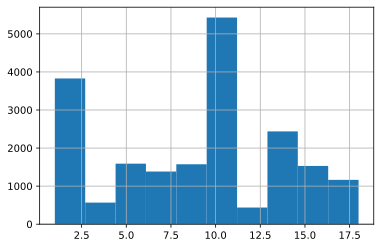

In [195]:
y.hist();

In [196]:
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=70, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=17, verbose=0,
                       warm_start=False)

# Простой пример на регрессию. 

In [101]:
import requests #импортируем модуль
f=open(r'Concrete_Data.xls','wb') #открываем файл для записи, в режиме wb
ufr = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls') #делаем запрос
f.write(ufr.content) 
f.close()
read_file = pd.read_excel (r'Concrete_Data.xls')#кастыль
read_file.to_csv (r'Concrete_Data.csv', index = None, header=True)

In [105]:
new_dat = pd.read_csv('Concrete_Data.csv' )

In [106]:
new_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
Cement (component 1)(kg in a m^3 mixture)                1030 non-null float64
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    1030 non-null float64
Fly Ash (component 3)(kg in a m^3 mixture)               1030 non-null float64
Water  (component 4)(kg in a m^3 mixture)                1030 non-null float64
Superplasticizer (component 5)(kg in a m^3 mixture)      1030 non-null float64
Coarse Aggregate  (component 6)(kg in a m^3 mixture)     1030 non-null float64
Fine Aggregate (component 7)(kg in a m^3 mixture)        1030 non-null float64
Age (day)                                                1030 non-null int64
Concrete compressive strength(MPa, megapascals)          1030 non-null float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [107]:
new_dat

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.284354
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.178794
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036


In [108]:
new_corr_matrix = new_dat.corr()

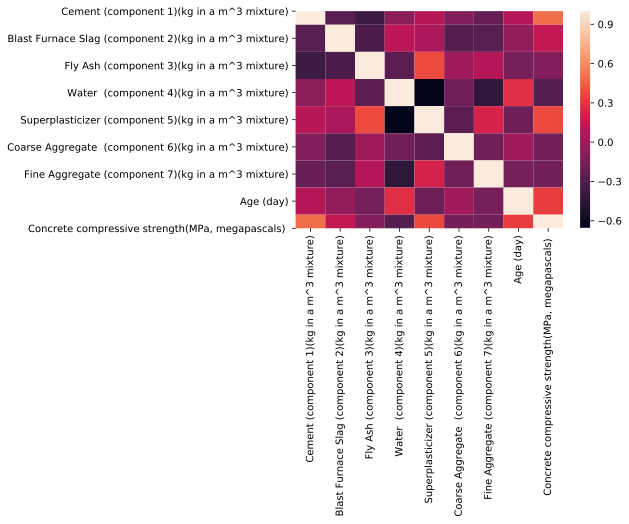

In [109]:
sns.heatmap(new_corr_matrix);

In [110]:
new_dat.columns

Index(['Cement (component 1)(kg in a m^3 mixture)',
       'Blast Furnace Slag (component 2)(kg in a m^3 mixture)',
       'Fly Ash (component 3)(kg in a m^3 mixture)',
       'Water  (component 4)(kg in a m^3 mixture)',
       'Superplasticizer (component 5)(kg in a m^3 mixture)',
       'Coarse Aggregate  (component 6)(kg in a m^3 mixture)',
       'Fine Aggregate (component 7)(kg in a m^3 mixture)', 'Age (day)',
       'Concrete compressive strength(MPa, megapascals) '],
      dtype='object')

In [111]:

rename_dic = dict(zip(new_dat.columns, 
                      ['Cement (component 1)',
       'Blast Furnace Slag (component 2))',
       'Fly Ash (component 3)',
       'Water  (component 4)',
       'Superplasticizer (component 5)',
       'Coarse Aggregate  (component 6)',
       'Fine Aggregate (component 7)', 'Age (day)',
       'Concrete compressive strength']))

In [112]:
new_dat.rename(columns=rename_dic, inplace=True)

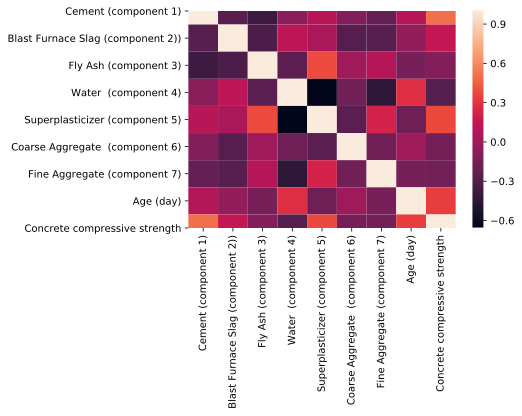

In [113]:
new_corr_matrix = new_dat.corr()
sns.heatmap(new_corr_matrix);

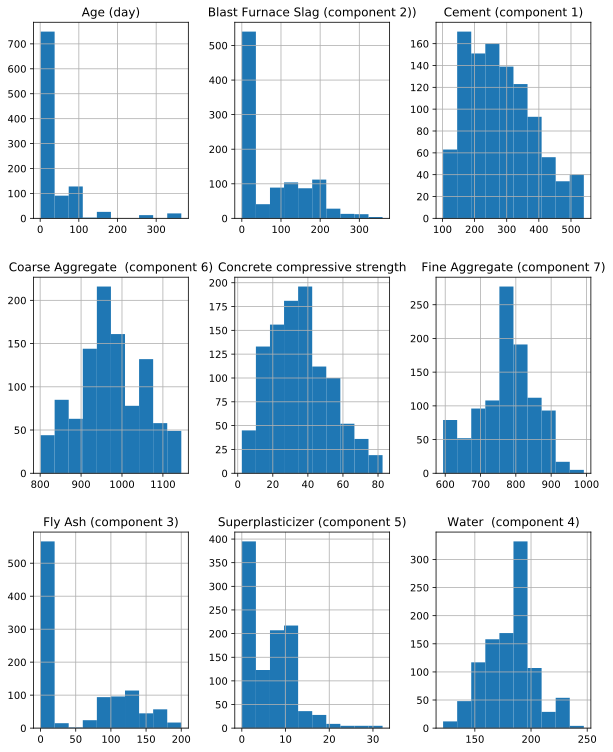

In [114]:
new_dat.hist(bins=10,figsize=(10,13));

In [115]:
testY=new_dat['Concrete compressive strength']
testX=new_dat.drop(['Concrete compressive strength'],axis=1)
X_train,X_valid, y_train,y_valid=train_test_split(testX,testY,test_size=0.3)

In [116]:
X_valid.shape

(309, 8)

In [117]:
from catboost import Pool, CatBoostRegressor
# пул данных - можно и не писать так а просто передать их в явном виде
train_pool = Pool(X_train, 
                  y_train)

# наша модель (5000- число повторений, 0,3 - скорость обучения, MAE - функция ошибки)
model = CatBoostRegressor(iterations=5000, learning_rate=0.3,  loss_function='MAE')
#тренируем
model.fit(train_pool,eval_set=(X_valid,y_valid), plot=True,verbose=False);
#смотрим на график




MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [118]:
model.best_score_

{'learn': {'MAE': 0.35454262110741075},
 'validation': {'MAE': 2.5762462731869924}}

In [119]:
testX=scalerminmax.fit_transform(testX)
X_train,X_valid, y_train,y_valid=train_test_split(testX,testY,test_size=0.3)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
scalerminmax = MinMaxScaler(feature_range=(-1,1))
X_train=scalerminmax.fit_transform(X_train)



In [120]:
train_pool = Pool(X_train, 
                  y_train)

# наша модель (5000- число повторений, 0,3 - скорость обучения, MAE - функция ошибки)
model = CatBoostRegressor(iterations=5000, learning_rate=0.3,  loss_function='MAE')
#тренируем
model.fit(train_pool,eval_set=(X_valid,y_valid), plot=True,verbose=False);
#смотрим на график

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [121]:
model.best_score_

{'learn': {'MAE': 0.35162451162877506},
 'validation': {'MAE': 2.7793389924121548}}

In [ ]:
print(model.get_all_params())

И так :
    1. Если в данных есть пропуски - данные пропуски можно или удалить или заменить например на среднее значение в поле (зависит от данных)
    2. Исключение выбросов может приводить к удалению важных данных - особенно в задачах классификации когда одни данные явно выделяются от других. 
    3. Для удобства визуализации временами стоит уменьшать (изменять) поля данных.
    4. Приведение к диапазону при решении задач классификации с использованием случайного леса слабо влияет на результат.
    5. Приведение к диапазону при решении задач регрессии - может дать и отрицательный результат (все зависит от ошибки, метода и т п)
    6. Корреляция данных показывает как одни параметры зависят от других. А так же можно увидеть направление изменения одних значений от других.
    7. Цветные графики корреляции помогают понять как зависят данные.

    
    